In [1]:
import json
import os
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import keras
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,Merge
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.models.keyedvectors as word2vec
from gensim.models.keyedvectors import KeyedVectors

from keras import backend as K

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
glove2word2vec(glove_input_file="glove.6B.50d.txt", word2vec_output_file="gensim_glove_vectors.txt")
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

In [3]:
from scipy import stats

In [4]:
def filter_sentence(text):
    #tokenizer = RegexpTokenizer(r'\w+')
    tokenizer = RegexpTokenizer(r'[A-z]+')
    stop_words = set(stopwords.words('english'))
    word_tokens = [string.lower() for string in tokenizer.tokenize(text)]
    #word_tokens = [w for w in word_tokens if not w in stop_words]
    #word_tokens = [w for w in word_tokens if len(w)>2]
    return word_tokens

In [5]:
def get_pd_frame_by_topics(topics):
    folder_names = topics
    

    non_rumour_json_obj = []
    non_rumour_json_obj_reactions = []
    for name in folder_names:
        non_rumours_paths = "pheme-rnr-dataset/"+name+"/non-rumours/"
        non_rumours_path = [x for x in os.listdir(non_rumours_paths)]
        for subfolder in non_rumours_path:
            subfolder_path = non_rumours_paths + subfolder + "/source-tweet/"
            json_files = [pos_json for pos_json in os.listdir(subfolder_path) if pos_json.endswith('.json')]
            json_file = json_files[0]
            json_file_path = subfolder_path + json_file
            with open(json_file_path) as json_data:
                d = json.load(json_data)
                non_rumour_json_obj.append(d)
            subfolder_path = non_rumours_paths + subfolder + "/reactions/"
            json_files = [pos_json for pos_json in os.listdir(subfolder_path) if pos_json.endswith('.json')]
            reactions = []
            for json_file in json_files:
                json_file_path = subfolder_path + json_file
                with open(json_file_path) as json_data:
                    d = json.load(json_data)
                    reactions.append(d)
            non_rumour_json_obj_reactions.append(reactions)
    rumour_json_obj = []
    rumour_json_obj_reactions = []
    for name in folder_names:
        rumours_paths = "pheme-rnr-dataset/"+name+"/rumours/"
        rumours_path = [x for x in os.listdir(rumours_paths)]
        for subfolder in rumours_path:
            subfolder_path = rumours_paths + subfolder + "/source-tweet/"
            json_files = [pos_json for pos_json in os.listdir(subfolder_path) if pos_json.endswith('.json')]
            json_file = json_files[0]
            json_file_path = subfolder_path + json_file
            #print(json_file_path)
            with open(json_file_path) as json_data:
                d = json.load(json_data)
                rumour_json_obj.append(d)
            subfolder_path = rumours_paths + subfolder + "/reactions/"
            json_files = [pos_json for pos_json in os.listdir(subfolder_path) if pos_json.endswith('.json')]
            reactions = []
            for json_file in json_files:
                json_file_path = subfolder_path + json_file
                with open(json_file_path) as json_data:
                    d = json.load(json_data)
                    reactions.append(d)
            rumour_json_obj_reactions.append(reactions)

    retweet_count = []
    text = []
    created = []
    followers_count = []
    verified = []
    statuses_count = []
    user_age = []
    rumour = []
    final_reactions = []
    

    for elem,react in zip(non_rumour_json_obj,non_rumour_json_obj_reactions):
        retweet_count.append(elem['retweet_count'])
        text.append(elem['text'])
        created.append(elem['created_at'])
        followers_count.append(elem['user']['followers_count'])
        verified.append(elem['user']['verified'])
        statuses_count.append(elem['user']['statuses_count'])
        user_age.append(elem['user']['created_at'])
        rumour.append('non_rumour')
        concat_reactions = ""
        if len(react)==0:
            concat_reactions = 'default'
        for r in react:
            try:
                concat_reactions = concat_reactions + r['text']
            except:
                try:
                    for rx in r:
                        concat_reactions = concat_reactions + rx['text']
                except:
                    print(len(rx))
        final_reactions.append(concat_reactions)    
    for elem,react in zip(rumour_json_obj,rumour_json_obj_reactions):
        retweet_count.append(elem['retweet_count'])
        text.append(elem['text'])
        reactions.append(react)
        created.append(elem['created_at'])
        followers_count.append(elem['user']['followers_count'])
        verified.append(elem['user']['verified'])
        statuses_count.append(elem['user']['statuses_count'])
        user_age.append(elem['user']['created_at'])
        rumour.append('rumour')
        concat_reactions = ""
        if len(react)==0:
            concat_reactions = 'default'
        for r in react:
            try:
                concat_reactions = concat_reactions + r['text']
            except:
                try:
                    for rx in r:
                        concat_reactions = concat_reactions + rx['text']
                except:
                    print(rx)
                #break
            #print(react)
        final_reactions.append(concat_reactions)    
    df_temp = pd.DataFrame()
    df = pd.DataFrame()

    df_temp['retweet_count'] = retweet_count
    df_temp['text'] = text
    df_temp['created'] = created
    df_temp['followers_count'] = followers_count
    df_temp['verified'] = verified
    df_temp['statuses_count'] = statuses_count
    df_temp['user_age'] = user_age
    df_temp['rumour'] = rumour
    df_temp['reactions'] = final_reactions

    #df.count()
    #df_temp.to_csv('/home/dell/rumour.csv',sep=',')

    temp = pd.to_datetime(df_temp.created, format='%a %b %d %H:%M:%S +0000 %Y')

    df_temp = df_temp.sort_values(by='created')

    le = preprocessing.LabelEncoder()
    df_temp['verified_bool'] = le.fit_transform(df_temp['verified'])
    df_temp['rumour_bool'] = le.fit_transform(df_temp['rumour'])
    actual_labels = df_temp['rumour_bool']

    df = df_temp[['retweet_count','followers_count','verified_bool','statuses_count']]
    return df,df_temp

In [6]:
def convert_text_to_tokens(text,glove_model,max_length):
    tokens = []
    for t in text:
        token_line = filter_sentence(t)
        tokens.append(token_line)
    word_features = []

    not_found = 0
    text_features = []
    for token_line in tokens:
        line = []
        for token in token_line:
                try: 
                    word_vector = glove_model.get_vector(token)
                    line.append(word_vector)
                except:
                    not_found = not_found + 1
        text_features.append(line)

    # ##take average of features
    # avg_text_features = []
    # for lines in text_features:
    #     avg = np.zeros(50)
    #     count = 0
    #     for line in lines:
    #         avg = avg + line
    #         count = count + 1
    #     avg_text_features.append(avg)
    # word_avg_features = np.array(avg_text_features)
    # concat_features = np.concatenate((word_avg_features,df_text.as_matrix()),axis=1)

    lengths = []
    for line in text_features:
        lengths.append(len(line))
    print(max(lengths))


    lengths = []
    training_list_embedded = np.zeros(shape=(len(text_features),50,max_length))
    for i in range(len(text_features)):
        sentence = text_features[i]
        length = len(sentence)
        padded_sequence = []
        j = 1

        while(1):
                #print(j)
                if j>(max_length-length):
                    break
                padded_sequence.append(np.zeros(50))
                j = j + 1
        sentence = padded_sequence + sentence 
        training_list_embedded[i,:,:] = np.array(sentence).transpose()[:,:max_length]
    return training_list_embedded

In [7]:
def attention_layer(m1,k,L,dropout):
    WyY = Dense(k)(m1)
    WyY = Dropout(dropout)(WyY)
    hNS = Lambda(lambda x: x[:,-1], name='last_state')(m1)
    hN = RepeatVector(L)(hNS)
    merged = Dense(k)(hN)
    merged = Dropout(dropout)(merged)
    M = merge([merged,WyY],mode='sum')
    M = Lambda(lambda x: K.tanh(x), name='tan_h')(M)
    alpha = Dense(1,activation='softmax')(M)
    alpha = Dropout(dropout)(alpha)
    alpha = Flatten()(alpha)
    #r = Lambda(lambda x: K.dot(x[0],x[1]), name='mult')([alpha,m1])
    alpha = RepeatVector(k)(alpha)
    alpha = Permute((2,1))(alpha)
    r = merge([alpha,m1],mode='mul')
    r = Lambda(lambda x: K.sum(x,axis=1), name='sum_axis')(r)
    #r = merge([alpha,m1],mode='dot')
    WxhN = Dense(k)(hNS)
    WxhN = Dropout(dropout)(WxhN)
    Wpr = Dense(k)(r)
    Wpr = Dropout(dropout)(Wpr)
    h = merge([WxhN,Wpr],mode='sum')
    return h

In [8]:
####LSTM approach
def stacked_lstm(X_train,y_train,bsize,seq1_length,seq2_length):
    length =int(len(X_train)/bsize)*bsize
    dropout=0.55
    # create the model
    
    inp1 = Input(batch_shape=(bsize,50,seq1_length),name='input1')
    input1 = Permute((2,1))(inp1)
    m1 = LSTM(30,stateful=False,batch_size=bsize,name='model1',recurrent_dropout=dropout,return_sequences=True)(input1)
    
    h = attention_layer(m1,30,seq1_length,dropout)
    
    inp2 = Input(batch_shape=(bsize,50,seq2_length),name='input2')
    input2 = Permute((2,1))(inp2)
    m2 = LSTM(30,input_shape=(50,seq2_length),stateful=False,batch_size=bsize,name='model2',recurrent_dropout=dropout)(input2)
    
    merged = merge([h, m2],mode='concat')
    
    merged = Dense(10)(merged)
    reshaped2 = Dropout(dropout)(merged)
    main_output = Dense(1, activation='sigmoid',name='main_output')(reshaped2)
    model = Model(inputs=[inp1,inp2],outputs=[main_output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [9]:
#model = stacked_lstm(X_train,y_train,bsize,600,20)

In [10]:
folder_names = ["charliehebdo","ferguson","germanwings-crash","ottawashooting","sydneysiege"]
df_features,df_text = get_pd_frame_by_topics(folder_names)

[{'retweeted': False, 'contributors': None, 'id_str': '552809704603537409', 'in_reply_to_status_id': 552805735885991936, 'entities': {'urls': [{'display_url': 'youtube.com/watch?v=Q25dqD…', 'expanded_url': 'https://www.youtube.com/watch?v=Q25dqDgJwHU', 'indices': [74, 97], 'url': 'https://t.co/CukDPguk0U'}, {'display_url': 'minhajbooks.com/english/Downlo…', 'expanded_url': 'http://www.minhajbooks.com/english/Download/bid/384/Fatwa-Suicide-Bombing-and-Terrorism-French-by-Shaykh-ul-Islam-Dr-Muhammad-Tahir-ul-Qadri.html', 'indices': [99, 121], 'url': 'http://t.co/0m0hV86weU'}], 'user_mentions': [{'name': 'Telegraph News', 'screen_name': 'TelegraphNews', 'id': 14138785, 'indices': [0, 14], 'id_str': '14138785'}], 'symbols': [], 'hashtags': [{'text': 'ParisAttack', 'indices': [61, 73]}]}, 'in_reply_to_screen_name': 'TelegraphNews', 'retweet_count': 0, 'in_reply_to_status_id_str': '552805735885991936', 'favorite_count': 0, 'created_at': 'Wed Jan 07 12:51:18 +0000 2015', 'truncated': False, '

In [11]:
data_text = convert_text_to_tokens(df_text['text'],glove_model,20)
reactions_data = convert_text_to_tokens(df_text['reactions'],glove_model,800)

30
374113


In [12]:
labels = df_text['rumour_bool']
X_train, X_test, y_train, y_test = train_test_split(data_text, labels, test_size=0.33, random_state=42,shuffle = False)
X_train_reactions, X_test_reactions, _, _ = train_test_split(reactions_data, labels, test_size=0.33, random_state=42,shuffle = False)

In [13]:
bsize = 100
model = stacked_lstm(X_train,y_train,bsize,800,20)
length_train =int(len(X_train)/bsize)*bsize
length_test =int(len(X_test)/bsize)*bsize
history = model.fit([X_train_reactions[0:length_train],X_train[0:length_train]], np.array(y_train)[0:length_train], nb_epoch=15, batch_size=bsize,validation_data=([X_test_reactions[0:length_test],X_test[0:length_test]],y_test[0:length_test]))
import pickle
f = open('attention.pckl', 'wb')
pickle.dump(history.history, f)
f.close()

/home/dell/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/home/dell/.local/lib/python3.5/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/dell/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  app.launch_new_instance()
/home/dell/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/dell/.local/lib/pyth

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (100, 50, 800)       0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (100, 800, 50)       0           input1[0][0]                     
__________________________________________________________________________________________________
model1 (LSTM)                   (100, 800, 30)       9720        permute_1[0][0]                  
__________________________________________________________________________________________________
last_state (Lambda)             (100, 30)            0           model1[0][0]                     
__________________________________________________________________________________________________
repeat_vec

Epoch 11/15
3800/3800 [==============================] - 28s 7ms/step - loss: 1.0467 - acc: 0.6995 - val_loss: 0.6125 - val_acc: 0.7795
Epoch 12/15
3800/3800 [==============================] - 28s 7ms/step - loss: 0.8572 - acc: 0.7124 - val_loss: 0.6122 - val_acc: 0.7789
Epoch 13/15
3800/3800 [==============================] - 28s 7ms/step - loss: 0.7537 - acc: 0.7276 - val_loss: 0.5328 - val_acc: 0.7789
Epoch 14/15
3800/3800 [==============================] - 28s 7ms/step - loss: 0.6919 - acc: 0.7326 - val_loss: 0.5126 - val_acc: 0.7784
Epoch 15/15
3800/3800 [==============================] - 28s 7ms/step - loss: 0.6714 - acc: 0.7350 - val_loss: 0.5545 - val_acc: 0.7763


In [16]:
accuracies = []
k = 5
length = [500,600,700,800,1000]
for i in range(k):
    labels = df_text['rumour_bool']
    #num = np.random.randint(10,1000)
    data_text = convert_text_to_tokens(df_text['text'],glove_model,20)
    reactions_data = convert_text_to_tokens(df_text['reactions'],glove_model,length[i])
    X_train, X_test, y_train, y_test = train_test_split(data_text, labels, test_size=0.33, random_state=42,shuffle = False)
    X_train_reactions, X_test_reactions, _, _ = train_test_split(reactions_data, labels, test_size=0.33, random_state=42,shuffle = False)
    bsize = 100
    model = stacked_lstm(X_train,y_train,bsize,length[i],20)
    length_train =int(len(X_train)/bsize)*bsize
    length_test =int(len(X_test)/bsize)*bsize
    model.fit([X_train_reactions[0:length_train],X_train[0:length_train]], np.array(y_train)[0:length_train], nb_epoch=15, batch_size=bsize)
    loss,acc1 = model.evaluate([X_test_reactions[0:length_test],X_test[0:length_test]],y_test[0:length_test],batch_size=bsize)
    accuracies.append(acc1)

30
374113


/home/dell/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/home/dell/.local/lib/python3.5/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/dell/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  app.launch_new_instance()
/home/dell/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/dell/.local/lib/pyth

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (100, 50, 500)       0                                            
__________________________________________________________________________________________________
permute_20 (Permute)            (100, 500, 50)       0           input1[0][0]                     
__________________________________________________________________________________________________
model1 (LSTM)                   (100, 500, 30)       9720        permute_20[0][0]                 
__________________________________________________________________________________________________
last_state (Lambda)             (100, 30)            0           model1[0][0]                     
__________________________________________________________________________________________________
repeat_vec

/home/dell/.local/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Epoch 1/15
3800/3800 [==============================] - 18s 5ms/step - loss: 5.8738 - acc: 0.5347
Epoch 2/15
3800/3800 [==============================] - 16s 4ms/step - loss: 4.9166 - acc: 0.5811
Epoch 3/15
3800/3800 [==============================] - 16s 4ms/step - loss: 4.2871 - acc: 0.6097
Epoch 4/15
3800/3800 [==============================] - 16s 4ms/step - loss: 3.6579 - acc: 0.5921
Epoch 5/15
3800/3800 [==============================] - 16s 4ms/step - loss: 2.6249 - acc: 0.6397
Epoch 6/15
3800/3800 [==============================] - 16s 4ms/step - loss: 2.0468 - acc: 0.6653
Epoch 7/15
3800/3800 [==============================] - 16s 4ms/step - loss: 1.6436 - acc: 0.6603
Epoch 8/15
3800/3800 [==============================] - 16s 4ms/step - loss: 1.3274 - acc: 0.6766
Epoch 9/15
3800/3800 [==============================] - 16s 4ms/step - loss: 1.1300 - acc: 0.6850
Epoch 10/15
3800/3800 [==============================] - 16s 4ms/step - loss: 0.9445 - acc: 0.6989
Epoch 11/15
3800/38

Epoch 1/15
3800/3800 [==============================] - 22s 6ms/step - loss: 6.2579 - acc: 0.5421
Epoch 2/15
3800/3800 [==============================] - 20s 5ms/step - loss: 5.2962 - acc: 0.6097
Epoch 3/15
3800/3800 [==============================] - 20s 5ms/step - loss: 5.0835 - acc: 0.6032
Epoch 4/15
3800/3800 [==============================] - 19s 5ms/step - loss: 4.8056 - acc: 0.6197
Epoch 5/15
3800/3800 [==============================] - 19s 5ms/step - loss: 4.5535 - acc: 0.6437
Epoch 6/15
3800/3800 [==============================] - 19s 5ms/step - loss: 4.3363 - acc: 0.6461
Epoch 7/15
3800/3800 [==============================] - 19s 5ms/step - loss: 3.8931 - acc: 0.6442
Epoch 8/15
3800/3800 [==============================] - 19s 5ms/step - loss: 3.2493 - acc: 0.6750
Epoch 9/15
3800/3800 [==============================] - 19s 5ms/step - loss: 2.6857 - acc: 0.6937
Epoch 10/15
3800/3800 [==============================] - 19s 5ms/step - loss: 2.3180 - acc: 0.6979
Epoch 11/15
3800/38

Epoch 1/15
3800/3800 [==============================] - 24s 6ms/step - loss: 5.9244 - acc: 0.5766
Epoch 2/15
3800/3800 [==============================] - 23s 6ms/step - loss: 5.3379 - acc: 0.6318
Epoch 3/15
3800/3800 [==============================] - 23s 6ms/step - loss: 4.9630 - acc: 0.6208
Epoch 4/15
3800/3800 [==============================] - 22s 6ms/step - loss: 4.8295 - acc: 0.6061
Epoch 5/15
3800/3800 [==============================] - 22s 6ms/step - loss: 4.4048 - acc: 0.6311
Epoch 6/15
3800/3800 [==============================] - 22s 6ms/step - loss: 3.8237 - acc: 0.6492
Epoch 7/15
3800/3800 [==============================] - 22s 6ms/step - loss: 3.4833 - acc: 0.6458
Epoch 8/15
3800/3800 [==============================] - 22s 6ms/step - loss: 2.8933 - acc: 0.6763
Epoch 9/15
3800/3800 [==============================] - 22s 6ms/step - loss: 2.5910 - acc: 0.6711
Epoch 10/15
3800/3800 [==============================] - 24s 6ms/step - loss: 2.0800 - acc: 0.6797
Epoch 11/15
3800/38

Epoch 1/15
3800/3800 [==============================] - 26s 7ms/step - loss: 5.3797 - acc: 0.5742
Epoch 2/15
3800/3800 [==============================] - 24s 6ms/step - loss: 5.0475 - acc: 0.5979
Epoch 3/15
3800/3800 [==============================] - 26s 7ms/step - loss: 4.6155 - acc: 0.6142
Epoch 4/15
3800/3800 [==============================] - 25s 6ms/step - loss: 4.1786 - acc: 0.6147
Epoch 5/15
3800/3800 [==============================] - 24s 6ms/step - loss: 3.7832 - acc: 0.6350
Epoch 6/15
3800/3800 [==============================] - 26s 7ms/step - loss: 3.1129 - acc: 0.6689
Epoch 7/15
3800/3800 [==============================] - 26s 7ms/step - loss: 2.7377 - acc: 0.6763
Epoch 8/15
3800/3800 [==============================] - 24s 6ms/step - loss: 2.2854 - acc: 0.6797
Epoch 9/15
3800/3800 [==============================] - 23s 6ms/step - loss: 2.0124 - acc: 0.6879
Epoch 10/15
3800/3800 [==============================] - 23s 6ms/step - loss: 1.5946 - acc: 0.7092
Epoch 11/15
3800/38

Epoch 1/15
3800/3800 [==============================] - 33s 9ms/step - loss: 5.7705 - acc: 0.6039
Epoch 2/15
3800/3800 [==============================] - 30s 8ms/step - loss: 5.4154 - acc: 0.6400
Epoch 3/15
3800/3800 [==============================] - 30s 8ms/step - loss: 5.4014 - acc: 0.6321
Epoch 4/15
3800/3800 [==============================] - 30s 8ms/step - loss: 5.0717 - acc: 0.6263
Epoch 5/15
3800/3800 [==============================] - 30s 8ms/step - loss: 4.8360 - acc: 0.6300
Epoch 6/15
3800/3800 [==============================] - 30s 8ms/step - loss: 4.6621 - acc: 0.6308
Epoch 7/15
3800/3800 [==============================] - 30s 8ms/step - loss: 3.8675 - acc: 0.6497
Epoch 8/15
3800/3800 [==============================] - 30s 8ms/step - loss: 3.4336 - acc: 0.6597
Epoch 9/15
3800/3800 [==============================] - 30s 8ms/step - loss: 2.7722 - acc: 0.6818
Epoch 10/15
3800/3800 [==============================] - 30s 8ms/step - loss: 2.3745 - acc: 0.6879
Epoch 11/15
3800/38

[0.7694736844614932, 0.7673684264484205, 0.7678947385988737, 0.7773684231858504, 0.7863157893482008]


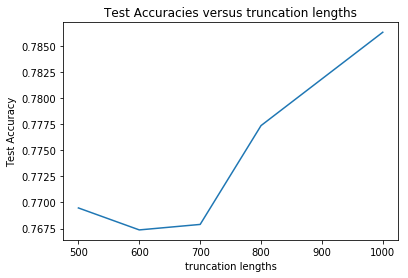

In [25]:
print(accuracies)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(length,accuracies)
plt.xlabel('truncation lengths')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracies versus truncation lengths')
plt.savefig('truncation_length_image.png')

In [15]:
accuracies = []
k = 5
for i in range(k):
    labels = df_text['rumour_bool']
    num = np.random.randint(10,1000)
    X_train, X_test, y_train, y_test = train_test_split(data_text, labels, test_size=0.33, random_state=num,shuffle = False)
    X_train_reactions, X_test_reactions, _, _ = train_test_split(reactions_data, labels, test_size=0.33, random_state=num,shuffle = False)
    bsize = 100
    model = stacked_lstm(X_train,y_train,bsize,800,20)
    length_train =int(len(X_train)/bsize)*bsize
    length_test =int(len(X_test)/bsize)*bsize
    model.fit([X_train_reactions[0:length_train],X_train[0:length_train]], np.array(y_train)[0:length_train], nb_epoch=15, batch_size=bsize)
    loss,acc1 = model.evaluate([X_test_reactions[0:length_test],X_test[0:length_test]],y_test[0:length_test],batch_size=bsize)
    accuracies.append(acc1)

0.7738947378961664
0.014446767839871573
[0.772105264036279, 0.7910526332102323, 0.7494736878495467, 0.7857894709235743, 0.7710526334611993]


In [121]:
model.evaluate([X_test_reactions[0:length_test],X_test[0:length_test]],y_test[0:length_test],batch_size=bsize)

1900/1900 [==============================] - 3s 2ms/step


[0.6540304661581391, 0.7510526337121662]

In [33]:
f = open('attention.pckl', 'rb')
obj = pickle.load(f)
f.close()

In [31]:
####LSTM approach
def conditioned_lstm(X_train,y_train,bsize,seq1_length,seq2_length):
    length =int(len(X_train)/bsize)*bsize
    
    dropout = 0.55
    inp1 = Input(batch_shape=(bsize,50,seq1_length),name='input1')
    input1 = Permute((2,1))(inp1)
    lstm1 = LSTM(30,stateful=False,batch_size=bsize,name='model1',return_state=True,recurrent_dropout=dropout,return_sequences=True)
    encoder_outputs, state_h, state_c  = lstm1(input1)
    
    inp2 = Input(batch_shape=(bsize,50,seq2_length),name='input2')
    input2 = Permute((2,1))(inp2)
    lstm2 = LSTM(30,stateful=False,batch_size=bsize,name='model2',recurrent_dropout=dropout,return_sequences=True)
    m2 = lstm2(input2,initial_state=[state_h, state_c])
    m2 = attention_layer(m2,30,seq2_length,dropout)
    
    
    merged = Dense(10)(m2)
    reshaped2 = Dropout(dropout)(merged)
    main_output = Dense(1, activation='sigmoid',name='main_output')(reshaped2)
    model = Model(inputs=[inp1,inp2],outputs=[main_output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    #model.fit([X_train[0:length]], np.array(y_train)[0:length], nb_epoch=40, batch_size=bsize)
    return model

In [34]:
bsize = 100
model = conditioned_lstm(X_train,y_train,bsize,20,800)
length_train =int(len(X_train)/bsize)*bsize
length_test =int(len(X_test)/bsize)*bsize
history = model.fit([X_train[0:length_train],X_train_reactions[0:length_train]], np.array(y_train)[0:length_train], nb_epoch=25, batch_size=bsize,validation_data=([X_test[0:length_test],X_test_reactions[0:length_test]],y_test[0:length_test]))
import pickle
f = open('conditioned_attention.pckl', 'wb')
pickle.dump(history.history, f)
f.close()

/home/dell/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/home/dell/.local/lib/python3.5/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/dell/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  app.launch_new_instance()
/home/dell/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/dell/.local/lib/pyth

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (100, 50, 20)        0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (100, 50, 800)       0                                            
__________________________________________________________________________________________________
permute_28 (Permute)            (100, 20, 50)        0           input1[0][0]                     
__________________________________________________________________________________________________
permute_29 (Permute)            (100, 800, 50)       0           input2[0][0]                     
__________________________________________________________________________________________________
model1 (LS

KeyboardInterrupt: 

In [109]:
model.evaluate([X_test_reactions[0:length_test],X_test[0:length_test]],y_test[0:length_test],batch_size=bsize)

1900/1900 [==============================] - 3s 1ms/step


[0.5078082853241971, 0.7794736874730963]

In [108]:
model.fit([X_train_reactions[0:length_train],X_train[0:length_train]], np.array(y_train)[0:length_train], nb_epoch=10, batch_size=bsize)

/home/dell/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/10
3800/3800 [==============================] - 19s 5ms/step - loss: 0.4400 - acc: 0.8032
Epoch 2/10
3800/3800 [==============================] - 20s 5ms/step - loss: 0.4427 - acc: 0.8026
Epoch 3/10
3800/3800 [==============================] - 20s 5ms/step - loss: 0.4303 - acc: 0.8053
Epoch 4/10
3800/3800 [==============================] - 20s 5ms/step - loss: 0.4246 - acc: 0.8071
Epoch 5/10
3800/3800 [==============================] - 20s 5ms/step - loss: 0.4204 - acc: 0.8150
Epoch 6/10
3800/3800 [==============================] - 21s 5ms/step - loss: 0.4214 - acc: 0.8163
Epoch 7/10
3800/3800 [==============================] - 20s 5ms/step - loss: 0.4044 - acc: 0.8237
Epoch 8/10
3800/3800 [==============================] - 18s 5ms/step - loss: 0.4050 - acc: 0.8224
Epoch 9/10
3800/3800 [==============================] - 19s 5ms/step - loss: 0.4009 - acc: 0.8239
Epoch 10/10
3800/3800 [==============================] - 19s 5ms/step - loss: 0.3861 - acc: 0.8324


In [39]:
accuracies = []
k = 5
for i in range(k):
    labels = df_text['rumour_bool']
    num = np.random.randint(10,1000)
    X_train, X_test, y_train, y_test = train_test_split(data_text, labels, test_size=0.33, random_state=num,shuffle = False)
    X_train_reactions, X_test_reactions, _, _ = train_test_split(reactions_data, labels, test_size=0.33, random_state=num,shuffle = False)
    bsize = 100
    model = conditioned_lstm(X_train,y_train,bsize,800,20)
    length_train =int(len(X_train)/bsize)*bsize
    length_test =int(len(X_test)/bsize)*bsize
    model.fit([X_train_reactions[0:length_train],X_train[0:length_train]], np.array(y_train)[0:length_train], nb_epoch=15, batch_size=bsize)
    loss,acc1 = model.evaluate([X_test_reactions[0:length_test],X_test[0:length_test]],y_test[0:length_test],batch_size=bsize)
    accuracies.append(acc1)

/home/dell/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/home/dell/.local/lib/python3.5/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/dell/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  app.launch_new_instance()
/home/dell/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/dell/.local/lib/pyth

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (100, 50, 800)       0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (100, 50, 20)        0                                            
__________________________________________________________________________________________________
permute_39 (Permute)            (100, 800, 50)       0           input1[0][0]                     
__________________________________________________________________________________________________
permute_40 (Permute)            (100, 20, 50)        0           input2[0][0]                     
__________________________________________________________________________________________________
model1 (LS

1900/1900 [==============================] - 4s 2ms/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (100, 50, 800)       0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (100, 50, 20)        0                                            
__________________________________________________________________________________________________
permute_45 (Permute)            (100, 800, 50)       0           input1[0][0]                     
__________________________________________________________________________________________________
permute_46 (Permute)            (100, 20, 50)        0           input2[0][0]                     
____________________________________________________

3800/3800 [==============================] - 26s 7ms/step - loss: 0.5529 - acc: 0.7279
Epoch 14/15
3800/3800 [==============================] - 26s 7ms/step - loss: 0.5560 - acc: 0.7305
Epoch 15/15
1900/1900 [==============================] - 5s 3ms/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (100, 50, 800)       0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (100, 50, 20)        0                                            
__________________________________________________________________________________________________
permute_51 (Permute)            (100, 800, 50)       0           input1[0][0]                     
____________________________________________________

In [40]:
print(np.mean(accuracies))
print(np.std(accuracies))
print(accuracies)

0.7562105260397259
0.006953745324622126
[0.7636842100243819, 0.7563157897246512, 0.7615789488742226, 0.7436842102753488, 0.7557894713000247]


In [144]:
# clf = RandomForestClassifier(max_depth=2)
# X_train, X_test, y_train, y_test = train_test_split(df, actual_labels, test_size=0.33, random_state=42)

In [163]:
# clf.fit(X_train, y_train)
# pred = clf.predict(X_test)
# print(accuracy_score(pred,y_test))

In [146]:
####next attempt